## Logistic regression

- classification : binary -> output of probability [0, 1] given input belonging to a class

![title](resource/logistic_reg.png)

#### Logistic Function $g()$ 
- Two-class logistic regression
- $ y = A x + b$
- $ g(y) = A x + b $
- $g(y) = \frac {1} {1 + e^{-y}} = \frac {1} {1 + e^{-(A x + b)}}$
- $g(y)$ = Estimated probability that $y = 1$ given $x$


#### Softmax Function $g()$ 
- Multi-class logistic regression
- Generalization of logistic function

#### Cross Entropy Function $D()$
- $D(S, L) = L log S - (1-L)log(1-S)$
    - If L = 0 (label)
        - $D(S, 0) = - log(1-S)$
            - $- log(1-S)$: less positive if $S \longrightarrow 0 $
            - $- log(1-S)$: more positive if $S \longrightarrow 1 $ (BIGGER LOSS)
    - If L = 1 (label)
        - $D(S, 1) = log S$
            - $logS$: less negative if $S \longrightarrow 1 $
            - $logS$: more negative if $S \longrightarrow 0 $ (BIGGER LOSS)

In [1]:
import datetime
import sys

import math

print(-math.log(1-0.000001))
print(-math.log(1-0.999999)) # distance is large

1.000000500029089e-06
13.815510557935518


In [2]:
print(math.log(0.000001))
print(math.log(0.999999))

-13.815510557964274
-1.000000500029089e-06


#### Cross Entropy Loss $L$
- Goal: Minimizing Cross Entropy Loss
- $ L = \frac {1}{N} \sum_i D(g(Ax_i + b), L_i)$

1. load dataset
2. make dataset iterable
3. create model
4. instantiate loss class
5. instantiate optimizer
6. train

In [3]:
# MNIST
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [4]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

In [5]:
len(train_dataset)

60000

In [6]:
# train_dataset[0]

In [7]:
type(train_dataset[0])

tuple

In [8]:
# input matrix
train_dataset[0][0].size()

torch.Size([1, 28, 28])

In [9]:
# label
train_dataset[0][1]

5

In [10]:
# display MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [11]:
train_dataset[0][0].numpy().shape

(1, 28, 28)

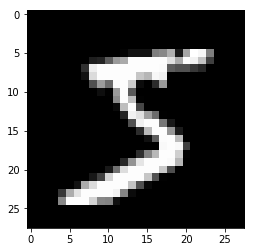

In [12]:
plt.imshow(train_dataset[0][0].numpy().reshape(28, 28), cmap='gray')

In [13]:
# test dataset

test_dataset = dsets.MNIST(root='./data',
                          train=False,
                          transform=transforms.ToTensor())
len(test_dataset)

10000

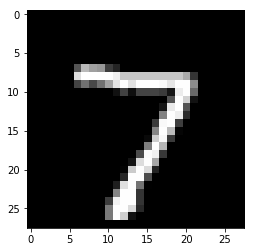

In [14]:
plt.imshow(test_dataset[0][0].numpy().reshape(28, 28), cmap='gray')

In [15]:
test_dataset[0][1]

7

## make dataset iterable

- total data : 60000
- minibatch = 100
- iterations : 3000 = 1 iteration = 1 mini-batch forward & backward
- epochs : 1 epoch = run through the whole dataset once
    - epochs = iterations / (total data / minibatch) = 3000 / (60000/100) = 5


In [16]:
batch_size = 100
n_iters = 3000
num_epochs = int(n_iters / (len(train_dataset) / batch_size))
num_epochs

5

In [17]:
# iterable object
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [18]:
import collections

isinstance(train_loader, collections.Iterable)

True

In [19]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [20]:
# model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

- input dimension (28*28 = 784)
- ouput dimension (10)

In [21]:
input_dim = 28*28
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)

Logistic Regression -> Cross Entropy Loss
- computes softmax

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
# instantiate optimizer
# at every itration, update model's parameters

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [24]:
model.parameters()

<generator object Module.parameters at 0x7f906eca4af0>

In [25]:
len(list(model.parameters()))

2

In [26]:
# FC 1 parameters
list(model.parameters())[0].size()

torch.Size([10, 784])

In [27]:
# FC bias parameters
list(model.parameters())[1].size()

torch.Size([10])

- Example 1: **matrix product**
    - $A: (100, 10)$
    - $B: (10, 1)$
    - $A \cdot B = (100, 10) \cdot (10, 1) = (100, 1)$
- Example 2: **matrix product**
    - $A: (50, 5)$
    - $B: (5, 2)$
    - $A \cdot B = (50, 5) \cdot (5, 2) = (50, 2)$
- Example 3: **element-wise addition**
    - $A: (10, 1)$
    - $B: (10, 1)$
    - $A + B = (10, 1)$

## train 
1. convert input/labels to variable
2. clear gradient
3. get output
4. get loss
5. get gradients
6. update parameters

In [28]:
start_time = datetime.datetime.now()
iter = 0
_show = True

for e in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss =criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        iter += 1
        if iter % 500 == 0:
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                images = Variable(images.view(-1, 28*28))
                outputs = model(images)
                
                _, predicted = torch.max(outputs.data, 1)
                
                # 구경하려고
                if iter == 500 and _show:
                    print(outputs.size()) # 100개 데이터
                    print(outputs[0, :])
                    
                    _show = False
                                    
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            accuracy = 100 * correct/total
            
            print('Iterations: {}, Loss: {}. Accuracy: {}'.format(iter, loss.data.item(), accuracy))
            
sys.stdout.write('Time '+ str(datetime.datetime.now() - start_time))

torch.Size([100, 10])
tensor([ 0.0124, -0.6328, -0.0777,  0.0038,  0.0043, -0.0814, -0.4338,  0.6234,
         0.2289,  0.4351], grad_fn=<SliceBackward>)
Iterations: 500, Loss: 1.8596142530441284. Accuracy: 67
Iterations: 1000, Loss: 1.5909916162490845. Accuracy: 75
Iterations: 1500, Loss: 1.2978323698043823. Accuracy: 78
Iterations: 2000, Loss: 1.2431268692016602. Accuracy: 80
Iterations: 2500, Loss: 1.0834710597991943. Accuracy: 81
Iterations: 3000, Loss: 1.0389509201049805. Accuracy: 82
epoch 4, loss 1.0389509201049805
Time 0:00:27.304720

In [29]:
a = np.ones(10)
b = np.ones(10)
(a==b).sum()

10

In [30]:
torch.save(model.state_dict(), 'logistic_model.pkl')